# GCN-AE sensitvity analysis for feature-only reconstruction with mini-batching

Runs on the `grunch` machine.

## Imports and setup

In [50]:
import time
import random
import itertools
import pickle
import os; os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import scipy as sp
import scipy.stats
from scipy.signal import savgol_filter
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot

from keras_tqdm import TQDMNotebookCallback as TQDMCallback
from tqdm import tqdm
from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching

In [30]:
sb.set()
MODEL_NAME = ('vae_'
              'l={l}_k={k}_p_out={p_out}_p_in={p_in}_'
              'use_bias={use_bias}_'
              'mini_batch_size={mini_batch_size}_mini_batch_walk_length={mini_batch_walk_length}')
MODEL_PATH = 'data/issue-19-mini-batch-validation/{}.pkl'

In [57]:
results_names = sorted(
    map(lambda name: name[:-4],
        filter(lambda name: name.endswith('.pkl'),
               os.listdir(os.path.join(*os.path.split(MODEL_PATH)[:-1])))
       )
)

In [58]:
def format_name(name):
    if name.startswith('vae_'):
        name = name[4:]
    p_out_index = name.find('p_out')
    bias_index = name.find('use_bias')
    mini_batch_index = name.find('mini_batch_size')
    walk_index = name.find('mini_batch_walk_length')
    return (name[:p_out_index - 1] + '\n' +
            name[p_out_index:bias_index - 1] + '\n' +
            name[bias_index:mini_batch_index - 1] + '\n' +
            name[mini_batch_index:walk_index - 1] + '\n' +
            name[walk_index:])

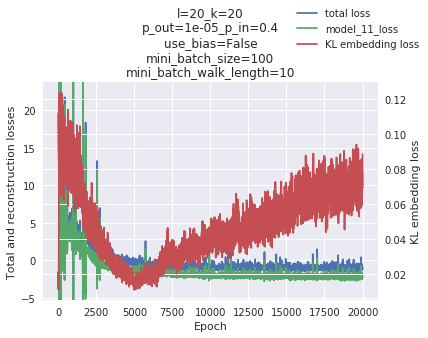

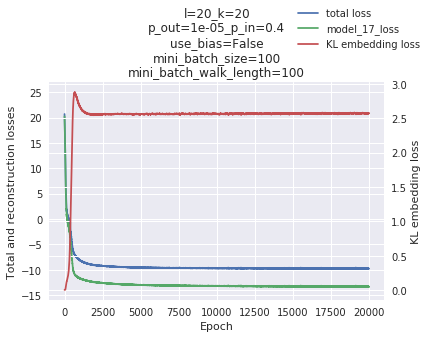

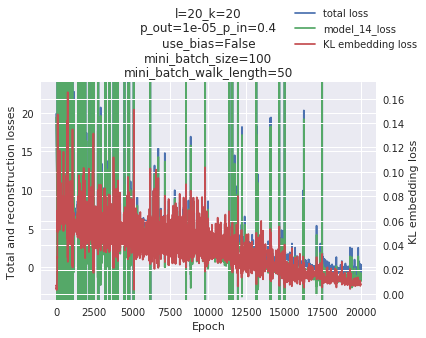

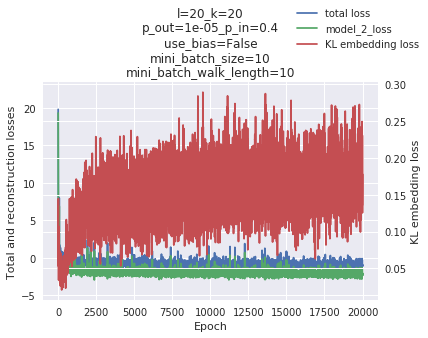

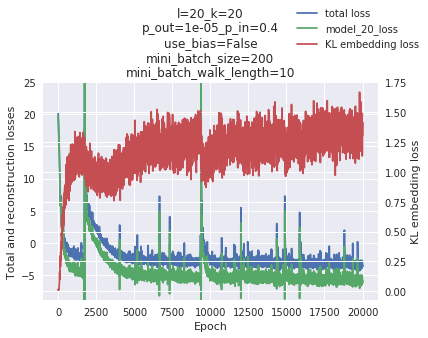

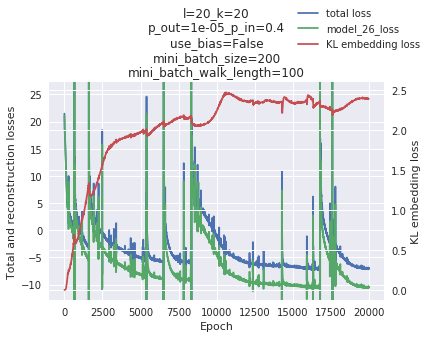

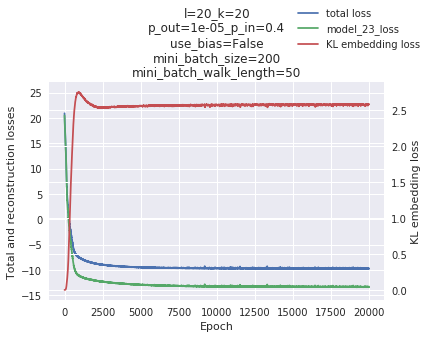

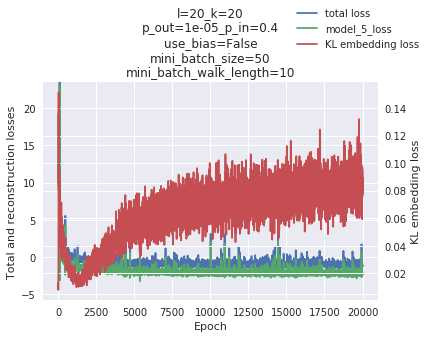

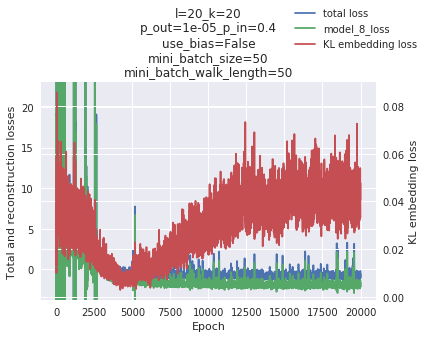

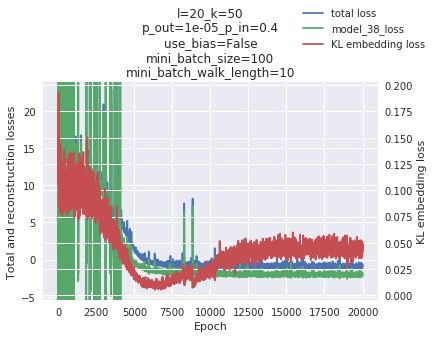

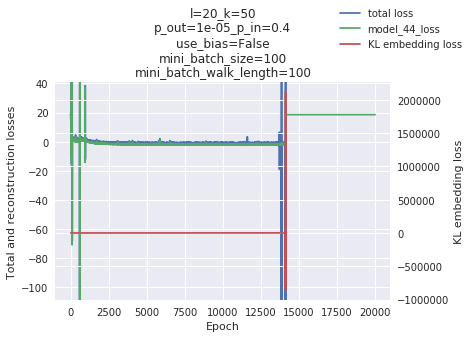

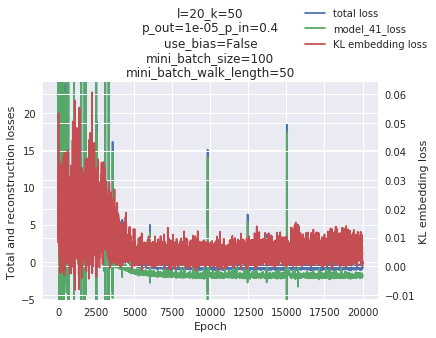

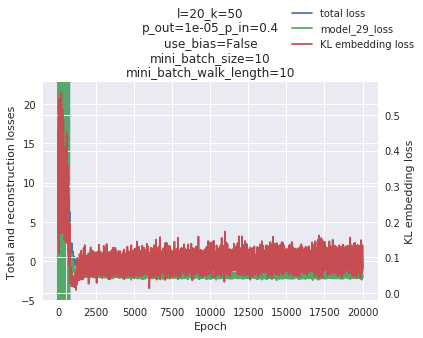

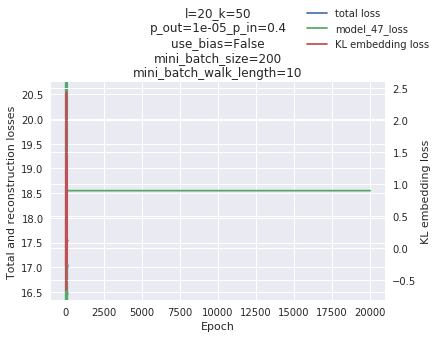

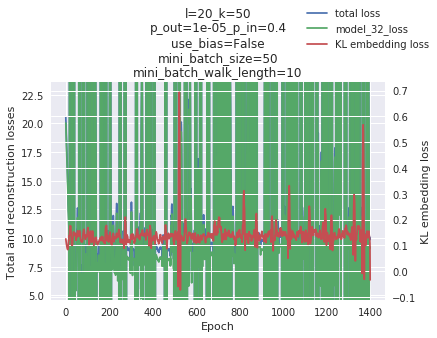

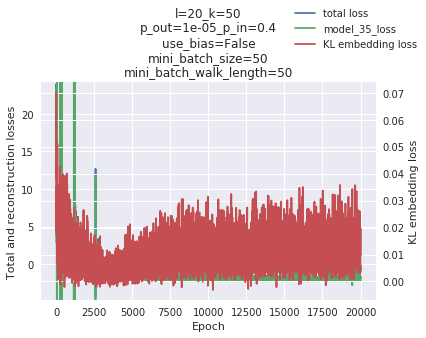

In [59]:
colormap = sb.color_palette()
savgol_window = 11
savgol_order = 2

for results_name in results_names:
    with open(MODEL_PATH.format(results_name), 'rb') as f:
        results = pickle.load(f)

    training = results['trainings'][0]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    model_n_loss = list(filter(lambda k: k.startswith('model_'), training.history.keys()))[0]

    ax1.plot(savgol_filter(training.history['loss'], savgol_window, savgol_order),
             label='total loss', color=colormap[0])
    ax1.plot(savgol_filter(training.history[model_n_loss], savgol_window, savgol_order),
             label=model_n_loss, color=colormap[1])
    ax2.plot(savgol_filter(training.history['q_mulogDu_flat_loss'], savgol_window, savgol_order),
             label='KL embedding loss', color=colormap[2])
    
    ylims = [training.history['loss'][-1], training.history['loss'][0]]
    if np.isnan(ylims[0]):
        ylims[0] = np.nanmin(training.history['loss'])
    ylims = ylims + np.array([-1, 1]) * (ylims[1] - ylims[0]) * .2
    ax1.set_ylim(ylims)
    ax1.set_title(format_name(results_name))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total and reconstruction losses')
    ax2.set_ylabel('KL embedding loss')
    fig.legend()